In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import find_contours, label, regionprops
from scipy.spatial.distance import cdist


In [2]:
# Find the start of the petiole
def extract_petiole_start_pt(leaf_mask):
    # If the leaf mask is noisy we mark the various "patches" with different labels
    labels = label(leaf_mask, connectivity=2)
    props = regionprops(labels)

    # Pick up only the largest "patch"
    idx_max_area = np.argmax([x['area'] for x in props])
    main_mask = labels == props[idx_max_area]['label']
    
    # Compute the mass center of the mask
    main_centroid = np.array(props[idx_max_area]['centroid']).reshape((1, 2))
    all_pix_coords = np.transpose(np.nonzero(main_mask))
    
    # The farthest pixel from the mass center is the start of the petiole
    farthest_pix_idx = np.argmax(cdist(main_centroid, all_pix_coords))
    return all_pix_coords[farthest_pix_idx:(farthest_pix_idx + 1), :]



# Extract leaf contour
def extract_leaf_contour(leaf_mask):
    return find_contours(leaf_mask)[0]



# Rotate the contour so that it starts at the base of the petiole
# "pt_towards_plant_center" is a point towards the center of the plant, not the center of the leaf.
def make_contour_start_at_petiole_base(leaf_contour, pt_towards_plant_center):
    petiole_start_idx = np.argmin(cdist(pt_towards_plant_center, leaf_contour))
    return np.roll(leaf_contour, -petiole_start_idx, axis = 0)



# Calculate the length of each contour segment and return the cumulative contour length 
def cumulative_contour_length(contour):
    contour_length = np.zeros((len(contour),), dtype=float)
    contour_length[1:] = np.cumsum(np.sqrt(np.sum(np.square(contour[:-1, :] - contour[1:, :]),
                                                  axis=1)))
    return contour_length



# Take the length of a contour, map it to [0...1] and pick a point on the contour at the given ratio
def point_at_contour_ratio(contour, length_ratio, desired_ratio):
    # Pick the closest contour point after the given ratio
    idx = np.where(length_ratio >= desired_ratio)[0][0]
    if length_ratio[idx] == desired_ratio:
        # There is a precise contour point which is located at the desired ratio
        return contour[idx, :]
    
    # Find a point in between two contour points that lies at the desired point
    rest_ratio = desired_ratio - length_ratio[idx]
    rest_ratio_weigth = rest_ratio / (length_ratio[idx] - length_ratio[idx - 1])
    return (1 - rest_ratio_weigth) * contour[idx - 1, :] + rest_ratio_weigth * contour[idx, :]



# Extract leaf vein based on the leaf contour.
# "top_idx" represents the contour index of the top of the leaf
def extract_leaf_vein(leaf_contour, top_idx):
    # Compute left and right contours and the cumulative distances along each one,
    # as well as ratio values of each point along the contour it belongs to.
    left_contour = leaf_contour[:(1 + top_idx), :]
    right_contour = np.roll(leaf_contour, -1, axis=0)[(top_idx - 1):, :][::-1, :]  # Reverse order in order to start from petiole
    left_cum_length = cumulative_contour_length(left_contour)
    right_cum_length = cumulative_contour_length(right_contour)
    left_ratio = left_cum_length/left_cum_length[-1]
    right_ratio = right_cum_length/right_cum_length[-1] # 

    # Pick the number of desired points along the leaf vein
    n_pts = 20
    
    # Create leaf vein points as halfway points between points with the same ratio value on left and right contours
    leaf_vein = np.zeros((n_pts, 2), dtype=float)
    for i_pt in range(n_pts):
        curr_ratio = i_pt / (n_pts - 1)
        
        # Leaf vein points are calculated as halfway through the distance between
        # the points on left/right contours located at the same relative ratio
        leaf_vein[i_pt, :] = (point_at_contour_ratio(left_contour, left_ratio, curr_ratio) 
                              + point_at_contour_ratio(right_contour, right_ratio, curr_ratio)) / 2.0
    return leaf_vein



# Calculate a moving average along a given data vector "a"
# If radius is 2 the moving window has 1+2*radius size (1 for the middle element) 
def moving_average(a, radius):
    # w_sz is the window size
    w_sz = 1 + 2 * radius
    avg_res = np.zeros_like(a, dtype=float)
    
    # Compute cumulative sum
    a_cumsum = np.zeros((1 + a.size), dtype=float)  # One artificial zero is added at the beginning
    a_cumsum[1:] = np.cumsum(a, dtype=float)
    
    # Most average values can be computed as differences between the cumulative sum values at locations
    # found at w_sz distance from each other
    avg_res[radius:(a.size - radius)] = (a_cumsum[w_sz:] - a_cumsum[:(a.size - w_sz + 1)]) / w_sz
    
    # Some values at the beginning and at the end need special attention
    avg_res[0] = a[0]
    avg_res[-1] = a[-1]
    for idx in range(1, radius):
        curr_w_sz = 1 + 2 * idx
        avg_res[idx] = a_cumsum[curr_w_sz] / curr_w_sz
        avg_res[a.size - idx - 1] = (a_cumsum[-1] - a_cumsum[a.size - curr_w_sz]) / curr_w_sz        
    return avg_res


In [3]:
# Compute the intersection between an infinite line and a limited segment
# Points a and b define the line, points c and d define the segment
def line_segment_intersection(a, b, c, d):
    # The denominator comes from a special mathematical formula
    denominator = (a[0] - b[0]) * (c[1] - d[1]) - (a[1] - b[1]) * (c[0] - d[0])
    if denominator == 0:
        # The segment is parallel with the line. Return error.
        return False, None
    
    # Parametric values of the intersection:
    # t is between 0 and 1 if the intersection falls between the two points (a and b) of the line
    # u is between 0 and 1 if the intersection falls between the two points (c and d) of the segment
    t = ((a[0] - c[0]) * (c[1] - d[1]) - (a[1] - c[1]) * (c[0] - d[0])) / denominator
    u = ((a[0] - c[0]) * (a[1] - b[1]) - (a[1] - c[1]) * (a[0] - b[0])) / denominator

    # Check if lines actually intersect
    if (0 <= u <= 1):
        # Intersection falls inside the segment
        return True, np.array([a[0] + t * (b[0] - a[0]), a[1] + t * (b[1] - a[1])], dtype=float).reshape((1, 2))
    
    # Intersection falls outside the segment
    return False, None



# Compute the intersection between an infinite line (defined by two points) and a contour (a list of at least two points)
def line_contour_intersection(line, contour):
    intersection_pt = None
    min_intersection_dist = np.inf
    
    # Compute intersection of the line with each segment of the contour
    for seg_idx in range(contour.shape[0] - 1):
        intersection_found, curr_intersection_pt = line_segment_intersection(
            line[0, :], line[1, :], 
            contour[seg_idx, :], contour[seg_idx + 1, :])

        if intersection_found:
            curr_dist = cdist(line[:1, :], curr_intersection_pt)
            if curr_dist < min_intersection_dist:
                # Keep only the closest intersection
                intersection_pt = curr_intersection_pt
                min_intersection_dist = curr_dist
    return intersection_pt



# Compute the distance from a point to an infinite line by projecting it orthogonally to the line
def distance_from_pt_to_line(pt, line):
    return np.linalg.norm(np.cross(-np.diff(line, axis=0), line[0, :] - pt)) / np.linalg.norm(-np.diff(line, axis=0))


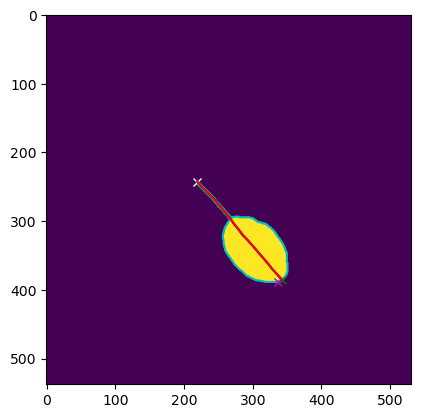

In [4]:
filename = ""  # Placeholder filename
root_path = ""  # Placeholder root path
# Construct the paths for the lobe and petiole masks
lobe_path = os.path.join(root_path, r'leaf seq\hidden leaf mask seq', filename)
petiole_path = os.path.join(root_path, r'stem seq\hidden stem mask seq', filename)

# Read and process lobe and petiole masks
lobe_mask = np.max(cv2.imread(lobe_path), axis=2).astype(bool)
petiole_mask = np.max(cv2.imread(petiole_path), axis=2).astype(bool)
leaf_mask = np.logical_or(lobe_mask, petiole_mask)

# Extract petiole start point, leaf contour, and vein
petiole_start_pt = extract_petiole_start_pt(leaf_mask)
leaf_contour = extract_leaf_contour(leaf_mask)
leaf_contour2 = make_contour_start_at_petiole_base(leaf_contour, petiole_start_pt)
top_idx = np.argmax(cdist(leaf_contour2[:1, :], leaf_contour2))
leaf_vein_initial = extract_leaf_vein(leaf_contour2, top_idx)

# Smooth leaf vein
w_radius = max(1, int(np.round((leaf_vein_initial.shape[0] - 1) / 20.0)))
leaf_vein = np.zeros_like(leaf_vein_initial, dtype=float)
leaf_vein[:, 0] = moving_average(leaf_vein_initial[:, 0], w_radius)
leaf_vein[:, 1] = moving_average(leaf_vein_initial[:, 1], w_radius)

# Plot leaf mask, contour, and vein
plt.imshow(leaf_mask.astype(float))
plt.plot(leaf_contour[:, 1], leaf_contour[:, 0], 'c')
plt.plot(leaf_contour2[0, 1], leaf_contour2[0, 0], 'wx')
plt.plot(leaf_contour2[top_idx, 1], leaf_contour2[top_idx, 0], 'gx')
plt.plot(leaf_contour[0, 1], leaf_contour[0, 0], 'mx')
plt.plot(leaf_vein_initial[:, 1], leaf_vein_initial[:, 0], 'k')
plt.plot(leaf_vein[:, 1], leaf_vein[:, 0], 'r')
plt.show()

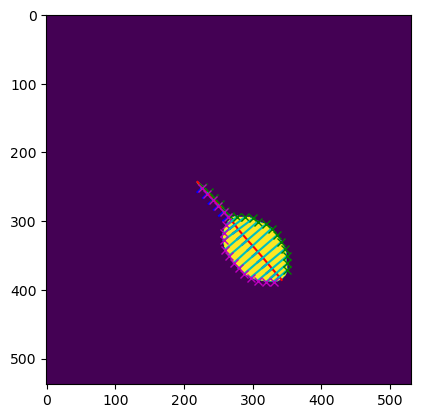

In [5]:
# Display leaf mask and vein
plt.imshow(leaf_mask.astype(float))
plt.plot(leaf_vein[:, 1], leaf_vein[:, 0], 'r')

# Initialize lists and distance
inters_pts_left = []
inters_pts_right = []
dists = [0.0]

# Iterate over segments of leaf vein
for seg_idx_vein in range(1, leaf_vein.shape[0] - 1):
    # Compute angle and orthogonal angle
    curr_angle = np.arctan2(leaf_vein[seg_idx_vein, 0] - leaf_vein[(seg_idx_vein - 1), 0], 
                            leaf_vein[seg_idx_vein, 1] - leaf_vein[(seg_idx_vein - 1), 1])
    ortho_angle = np.mod(np.pi/2.0 + curr_angle, np.pi)
    
    # Define a line orthogonal to the leaf vein segment
    line = leaf_vein[(seg_idx_vein - 1):(seg_idx_vein + 1), :][::-1, :].copy()
    line[1, 0] = line[0, 0] + 10 * np.sin(ortho_angle)
    line[1, 1] = line[0, 1] + 10 * np.cos(ortho_angle)
    
    # Plot the line
    plt.plot(line[:, 1], line[:, 0], 'b')
    
    # Find intersection points with leaf contour
    curr_inters_pt_left = line_contour_intersection(line, leaf_contour2[:(1+top_idx), :])
    curr_inters_pt_right = line_contour_intersection(line, leaf_contour2[top_idx:, :])
    
    # Append intersection points to lists
    inters_pts_left.append(curr_inters_pt_left)
    inters_pts_right.append(curr_inters_pt_right)
    
    # Plot intersection points
    plt.plot([curr_inters_pt_left[0, 1], curr_inters_pt_right[0, 1]],
             [curr_inters_pt_left[0, 0], curr_inters_pt_right[0, 0]],
             'c')
    plt.plot(curr_inters_pt_left[0, 1], curr_inters_pt_left[0, 0], 'gx')
    plt.plot(curr_inters_pt_right[0, 1], curr_inters_pt_right[0, 0], 'mx')
    
    # Calculate and append distance between intersection points
    dists.append(cdist(curr_inters_pt_left, curr_inters_pt_right)[0, 0])

# Append final distance
dists.append(0)

# Display plot
plt.show()

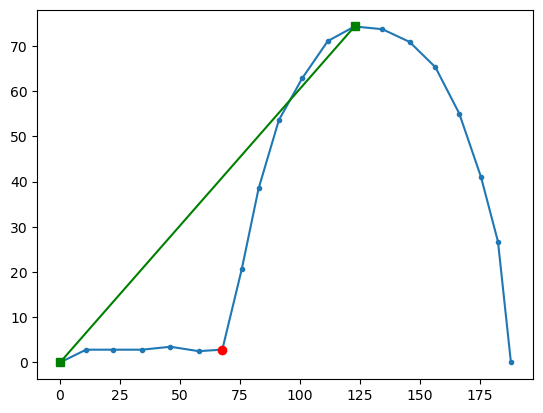

In [6]:
# Compute cumulative length of leaf vein
leaf_vein_length = cumulative_contour_length(leaf_vein)

# Find index of maximum distance
idx_max_dist = np.argmax(dists)

# Create line from the start to the point of maximum distance
ascending_line = np.array([[dists[0], leaf_vein_length[0]], [dists[idx_max_dist], leaf_vein_length[idx_max_dist]]])

# Initialize variables
petiole_end_idx = 0
max_dist = distance_from_pt_to_line(np.array([[dists[petiole_end_idx], leaf_vein_length[petiole_end_idx]]]), ascending_line)

# Iterate over points to find the end of petiole
for idx_pt in range(1, (1 + idx_max_dist)):
    # Calculate distance from point to line
    curr_dist = distance_from_pt_to_line(np.array([[dists[idx_pt], leaf_vein_length[idx_pt]]]), ascending_line)
    
    # Update maximum distance and petiole end index if current distance is greater
    if curr_dist > max_dist:
        max_dist = curr_dist
        petiole_end_idx = idx_pt

# Plot leaf vein length against distances and the ascending line
plt.plot(leaf_vein_length, dists, '.-')
plt.plot(ascending_line[:, 1], ascending_line[:, 0], 'gs-')

# Mark the end of petiole
plt.plot(leaf_vein_length[petiole_end_idx], dists[petiole_end_idx], 'ro')

# Show plot
plt.show()

In [ ]:
# The red point found on the leaf vein represents the limit between the petiole and the lobe